In [2]:
!pip install unidecode


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.5/235.5 kB 4.7 MB/s eta 0:00:00


In [3]:
import unidecode


In [4]:
import torch
import torch.nn as nn

# Set a random seed for reproducibility
seed = 1
torch.manual_seed(seed)

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import nltk
import unidecode

# Download stopwords for NLTK
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [5]:
# Đường dẫn tới file CSV
dataset_path = '/content/all-data.csv'

# Định nghĩa tiêu đề các cột
headers = ['sentiment', 'content']

# Đọc dữ liệu từ file CSV
df = pd.read_csv(
    dataset_path,
    names=headers,
    encoding='ISO-8859-1'
)


In [6]:
# Tạo dictionary để ánh xạ nhãn sentiment thành số nguyên
classes = {
    class_name: idx for idx, class_name in enumerate(df['sentiment'].unique().tolist())
}

# Áp dụng ánh xạ để chuyển đổi cột 'sentiment' từ chuỗi thành số nguyên
df['sentiment'] = df['sentiment'].apply(lambda x: classes[x])


In [7]:
print(classes)  # Hiển thị dictionary ánh xạ
print(df.head())  # Xem vài dòng đầu tiên của dataframe


{'neutral': 0, 'negative': 1, 'positive': 2}
   sentiment                                            content
0          0  According to Gran , the company has no plans t...
1          0  Technopolis plans to develop in stages an area...
2          1  The international electronic industry company ...
3          2  With the new production plant the company woul...
4          2  According to the company 's updated strategy f...


In [8]:
# Danh sách stopwords tiếng Anh
english_stop_words = stopwords.words('english')

# Tạo stemmer
stemmer = PorterStemmer()

# Hàm chuẩn hóa văn bản
def text_normalize(text):
    text = text.lower()  # Chuyển thành chữ thường
    text = unidecode.unidecode(text)  # Loại bỏ dấu (nếu có)
    text = text.strip()  # Loại bỏ khoảng trắng thừa ở đầu/cuối
    text = re.sub(r'[^\w\s]', '', text)  # Loại bỏ dấu câu
    text = ' '.join([word for word in text.split() if word not in english_stop_words])  # Xóa stopwords
    text = ' '.join([stemmer.stem(word) for word in text.split()])  # Áp dụng stemming
    return text


In [9]:
df['content'] = df['content'].apply(lambda x: text_normalize(x))


In [10]:
print(df.head())


   sentiment                                            content
0          0  accord gran compani plan move product russia a...
1          0  technopoli plan develop stage area less 100000...
2          1  intern electron industri compani elcoteq laid ...
3          2  new product plant compani would increas capac ...
4          2  accord compani updat strategi year 20092012 ba...


In [11]:
# Khởi tạo danh sách vocab
vocab = []

# Duyệt qua từng câu trong cột 'content'
for sentence in df['content'].tolist():
    tokens = sentence.split()  # Tách câu thành danh sách từ (tokens)
    for token in tokens:
        if token not in vocab:
            vocab.append(token)

# Thêm token đặc biệt 'UNK' và 'PAD'
vocab.append('UNK')
vocab.append('PAD')

# Tạo dictionary ánh xạ từ → index
word_to_idx = {word: idx for idx, word in enumerate(vocab)}

# Kích thước từ vựng
vocab_size = len(vocab)


In [12]:
print(f"Vocabulary size: {vocab_size}")
print(f"First 10 words in vocab: {vocab[:10]}")


Vocabulary size: 8908
First 10 words in vocab: ['accord', 'gran', 'compani', 'plan', 'move', 'product', 'russia', 'although', 'grow', 'technopoli']


In [13]:
def transform(text, word_to_idx, max_seq_len):
    tokens = []
    # Duyệt qua từng từ trong văn bản
    for w in text.split():
        try:
            w_ids = word_to_idx[w]  # Lấy ID từ bộ từ điển
        except KeyError:
            w_ids = word_to_idx['UNK']  # Nếu từ không có trong từ điển, dùng 'UNK'
        tokens.append(w_ids)

    # Chuẩn hóa độ dài của chuỗi
    if len(tokens) < max_seq_len:
        tokens += [word_to_idx['PAD']] * (max_seq_len - len(tokens))  # Thêm 'PAD' nếu ngắn
    elif len(tokens) > max_seq_len:
        tokens = tokens[:max_seq_len]  # Cắt chuỗi nếu dài hơn

    return tokens


In [14]:
# Kích thước tập validation và test
val_size = 0.2
test_size = 0.125

# Có trộn dữ liệu hay không
is_shuffle = True

# Chuyển dữ liệu từ DataFrame thành danh sách
texts = df['content'].tolist()
labels = df['sentiment'].tolist()

# Chia dữ liệu thành train và validation
X_train, X_val, y_train, y_val = train_test_split(
    texts, labels,
    test_size=val_size,
    random_state=seed,
    shuffle=is_shuffle
)

# Chia tiếp tập train thành train và test
X_train, X_test, y_train, y_test = train_test_split(
    X_train, y_train,
    test_size=test_size,
    random_state=seed,
    shuffle=is_shuffle
)


In [15]:
class FinancialNews(Dataset):
    def __init__(self, X, y, word_to_idx, max_seq_len, transform=None):
        """
        Khởi tạo dataset cho bài toán phân loại tin tức tài chính.

        Args:
            X (list): Danh sách văn bản.
            y (list): Danh sách nhãn.
            word_to_idx (dict): Từ điển ánh xạ từ → chỉ số.
            max_seq_len (int): Độ dài tối đa của chuỗi.
            transform (func): Hàm để chuyển đổi văn bản thành danh sách các chỉ số.
        """
        self.texts = X
        self.labels = y
        self.word_to_idx = word_to_idx
        self.max_seq_len = max_seq_len
        self.transform = transform

    def __len__(self):
        """Trả về số lượng mẫu trong dataset."""
        return len(self.texts)

    def __getitem__(self, idx):
        """
        Trả về một mẫu tại vị trí idx.

        Args:
            idx (int): Chỉ số của mẫu cần lấy.

        Returns:
            tuple: (text_tensor, label)
                   text_tensor: Dữ liệu văn bản dưới dạng tensor.
                   label: Nhãn tương ứng.
        """
        text = self.texts[idx]
        label = self.labels[idx]

        if self.transform:
            text = self.transform(
                text,
                self.word_to_idx,
                self.max_seq_len
            )
        # Chuyển đổi thành tensor
        text = torch.tensor(text, dtype=torch.long)

        return text, label


In [16]:
# Đặt độ dài tối đa của chuỗi
max_seq_len = 32

# Tạo các dataset cho tập train, validation, và test
train_dataset = FinancialNews(
    X_train, y_train,
    word_to_idx=word_to_idx,
    max_seq_len=max_seq_len,
    transform=transform
)

val_dataset = FinancialNews(
    X_val, y_val,
    word_to_idx=word_to_idx,
    max_seq_len=max_seq_len,
    transform=transform
)

test_dataset = FinancialNews(
    X_test, y_test,
    word_to_idx=word_to_idx,
    max_seq_len=max_seq_len,
    transform=transform
)

# Kích thước batch
train_batch_size = 128
test_batch_size = 8

# Tạo DataLoader cho các tập dữ liệu
train_loader = DataLoader(
    train_dataset,
    batch_size=train_batch_size,
    shuffle=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=test_batch_size,
    shuffle=False
)

test_loader = DataLoader(
    test_dataset,
    batch_size=test_batch_size,
    shuffle=False
)


In [17]:
class SentimentClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_size, n_layers, n_classes, dropout_prob):
        """
        Mô hình phân loại cảm xúc sử dụng RNN.

        Args:
            vocab_size (int): Kích thước từ vựng.
            embedding_dim (int): Số chiều của embedding.
            hidden_size (int): Số chiều của hidden state trong RNN.
            n_layers (int): Số lớp RNN.
            n_classes (int): Số lớp nhãn đầu ra.
            dropout_prob (float): Xác suất dropout.
        """
        super(SentimentClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.rnn = nn.RNN(embedding_dim, hidden_size, n_layers, batch_first=True)
        self.norm = nn.LayerNorm(hidden_size)
        self.dropout = nn.Dropout(dropout_prob)
        self.fc1 = nn.Linear(hidden_size, 16)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(16, n_classes)

    def forward(self, x):
        """
        Hàm chuyển tiếp dữ liệu qua mô hình.

        Args:
            x (Tensor): Input tensor (batch_size, seq_len).

        Returns:
            Tensor: Output tensor (batch_size, n_classes).
        """
        x = self.embedding(x)  # Embedding layer
        x, hn = self.rnn(x)   # RNN layer
        x = x[:, -1, :]       # Lấy hidden state cuối cùng
        x = self.norm(x)      # Normalization
        x = self.dropout(x)   # Dropout
        x = self.fc1(x)       # Fully connected layer 1
        x = self.relu(x)      # ReLU activation
        x = self.fc2(x)       # Fully connected layer 2
        return x


In [18]:
# Số lượng lớp đầu ra
n_classes = len(list(classes.keys()))

# Số chiều của embedding
embedding_dim = 64

# Số chiều của hidden state
hidden_size = 64

# Số lớp RNN
n_layers = 2

# Xác suất dropout
dropout_prob = 0.2

# Kiểm tra nếu có GPU thì sử dụng, nếu không sử dụng CPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Khởi tạo mô hình SentimentClassifier
model = SentimentClassifier(
    vocab_size=vocab_size,
    embedding_dim=embedding_dim,
    hidden_size=hidden_size,
    n_layers=n_layers,
    n_classes=n_classes,
    dropout_prob=dropout_prob
).to(device)  # Đưa mô hình lên thiết bị (GPU hoặc CPU)

# Kiểm tra mô hình
print(model)


SentimentClassifier(
  (embedding): Embedding(8908, 64)
  (rnn): RNN(64, 64, num_layers=2, batch_first=True)
  (norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (fc1): Linear(in_features=64, out_features=16, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=16, out_features=3, bias=True)
)


In [19]:
# Learning rate và số epochs
lr = 1e-4
epochs = 50

# Hàm mất mát (Loss function)
criterion = nn.CrossEntropyLoss()

# Optimizer (Adam)
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=lr
)

# Kiểm tra cấu hình của optimizer và loss function
print(f"Learning rate: {lr}")
print(f"Epochs: {epochs}")
print(f"Loss function: {criterion}")
print(f"Optimizer: {optimizer}")


Learning rate: 0.0001
Epochs: 50
Loss function: CrossEntropyLoss()
Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.0001
    maximize: False
    weight_decay: 0
)


In [20]:
def fit(model, train_loader, val_loader, criterion, optimizer, device, epochs):
    """
    Hàm huấn luyện mô hình.

    Args:
        model (nn.Module): Mô hình cần huấn luyện.
        train_loader (DataLoader): Bộ dữ liệu huấn luyện.
        val_loader (DataLoader): Bộ dữ liệu validation.
        criterion (nn.Module): Hàm mất mát.
        optimizer (torch.optim): Bộ tối ưu hóa.
        device (str): Thiết bị ('cuda' hoặc 'cpu').
        epochs (int): Số lượng epochs.

    Returns:
        tuple: train_losses, val_losses - danh sách loss trong mỗi epoch.
    """
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        batch_train_losses = []
        model.train()  # Chuyển mô hình sang chế độ train

        for idx, (inputs, labels) in enumerate(train_loader):
            # Đưa dữ liệu vào device
            inputs, labels = inputs.to(device), labels.to(device)

            # Đặt lại gradient
            optimizer.zero_grad()

            # Tính toán đầu ra và loss
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Lan truyền ngược (backpropagation) và cập nhật trọng số
            loss.backward()
            optimizer.step()

            # Ghi lại giá trị loss
            batch_train_losses.append(loss.item())

        # Tính toán loss trung bình cho epoch
        train_loss = sum(batch_train_losses) / len(batch_train_losses)
        train_losses.append(train_loss)

        # Đánh giá mô hình trên tập validation
        val_loss, val_acc = evaluate(model, val_loader, criterion, device)
        val_losses.append(val_loss)

        # In thông tin về epoch
        print(f'EPOCH {epoch + 1}:\tTrain loss: {train_loss:.4f}\tVal loss: {val_loss:.4f}\tVal acc: {val_acc:.4f}')

    return train_losses, val_losses


In [22]:
def evaluate(model, dataloader, criterion, device):
    """
    Hàm đánh giá mô hình trên tập dữ liệu.

    Args:
        model (nn.Module): Mô hình cần đánh giá.
        dataloader (DataLoader): Bộ dữ liệu validation hoặc test.
        criterion (nn.Module): Hàm mất mát.
        device (str): Thiết bị ('cuda' hoặc 'cpu').

    Returns:
        tuple: (loss trung bình, độ chính xác).
    """
    model.eval()  # Chuyển mô hình sang chế độ đánh giá (tắt dropout, batchnorm)
    correct = 0  # Số lượng dự đoán đúng
    total = 0  # Tổng số mẫu dữ liệu
    losses = []  # Danh sách lưu các giá trị loss

    with torch.no_grad():  # Tắt tính toán gradient để tiết kiệm tài nguyên
        for inputs, labels in dataloader:
            # Chuyển dữ liệu và nhãn sang thiết bị (GPU hoặc CPU)
            inputs, labels = inputs.to(device), labels.to(device)

            # Dự đoán đầu ra của mô hình
            outputs = model(inputs)

            # Tính toán hàm mất mát
            loss = criterion(outputs, labels)
            losses.append(loss.item())  # Lưu giá trị loss của batch

            # Lấy dự đoán nhãn bằng cách chọn giá trị lớn nhất
            _, predicted = torch.max(outputs.data, 1)

            # Tính tổng số mẫu và số lượng dự đoán đúng
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # Tính loss trung bình cho toàn bộ tập dữ liệu
    loss = sum(losses) / len(losses)

    # Tính độ chính xác (số dự đoán đúng / tổng số mẫu)
    acc = correct / total

    return loss, acc  # Trả về loss trung bình và độ chính xác


In [23]:
# Huấn luyện mô hình với hàm fit đã định nghĩa
train_losses, val_losses = fit(
    model=model,          # Mô hình SentimentClassifier đã khởi tạo
    train_loader=train_loader,  # DataLoader của tập huấn luyện
    val_loader=val_loader,      # DataLoader của tập validation
    criterion=criterion,  # Hàm mất mát CrossEntropy
    optimizer=optimizer,  # Optimizer Adam
    device=device,        # Thiết bị (GPU hoặc CPU)
    epochs=epochs         # Số lượng epochs (ví dụ: 50)
)


EPOCH 1:	Train loss: 1.0102	Val loss: 0.9541	Val acc: 0.5876
EPOCH 2:	Train loss: 0.9439	Val loss: 0.9338	Val acc: 0.5876
EPOCH 3:	Train loss: 0.9337	Val loss: 0.9294	Val acc: 0.5876
EPOCH 4:	Train loss: 0.9317	Val loss: 0.9286	Val acc: 0.5876
EPOCH 5:	Train loss: 0.9311	Val loss: 0.9283	Val acc: 0.5876
EPOCH 6:	Train loss: 0.9286	Val loss: 0.9283	Val acc: 0.5876
EPOCH 7:	Train loss: 0.9287	Val loss: 0.9283	Val acc: 0.5876
EPOCH 8:	Train loss: 0.9302	Val loss: 0.9284	Val acc: 0.5876
EPOCH 9:	Train loss: 0.9311	Val loss: 0.9282	Val acc: 0.5876
EPOCH 10:	Train loss: 0.9294	Val loss: 0.9282	Val acc: 0.5876
EPOCH 11:	Train loss: 0.9300	Val loss: 0.9281	Val acc: 0.5876
EPOCH 12:	Train loss: 0.9295	Val loss: 0.9283	Val acc: 0.5876
EPOCH 13:	Train loss: 0.9283	Val loss: 0.9282	Val acc: 0.5876
EPOCH 14:	Train loss: 0.9282	Val loss: 0.9281	Val acc: 0.5876
EPOCH 15:	Train loss: 0.9256	Val loss: 0.9280	Val acc: 0.5876
EPOCH 16:	Train loss: 0.9286	Val loss: 0.9279	Val acc: 0.5876
EPOCH 17:	Train l

Training Losses: [1.01019130591993, 0.9439342308927465, 0.9336521294381883, 0.931710441907247, 0.9311438975510774, 0.9285595836462798, 0.9286946698471352, 0.930213314515573, 0.9311422970559862, 0.929426943814313, 0.9300044355569063, 0.9294790426890055, 0.9282695651054382, 0.9282216231028239, 0.9255785169424834, 0.9285773215470491, 0.9275500575701395, 0.9319706117665326, 0.9265367896468552, 0.9272098475032382, 0.9269745592717771, 0.9296635168570059, 0.9249577500202038, 0.9273393132068493, 0.9273718176064668, 0.9250871472888522, 0.9256786549532855, 0.9269886833650095, 0.9246322733384592, 0.9243610722047312, 0.9254816571871439, 0.9236772104545876, 0.9210543654583119, 0.921755349194562, 0.9152093551777027, 0.9010310062655696, 0.9201279039736148, 0.8929368566583704, 0.8661754352075083, 0.8878340632827194, 0.8722971258340059, 0.8491133032021699, 0.8414958605059871, 0.834917562979239, 0.8283043371306525, 0.8189918685842443, 0.8229330822273537, 0.8122369558722885, 0.8024488025241427, 0.8003718

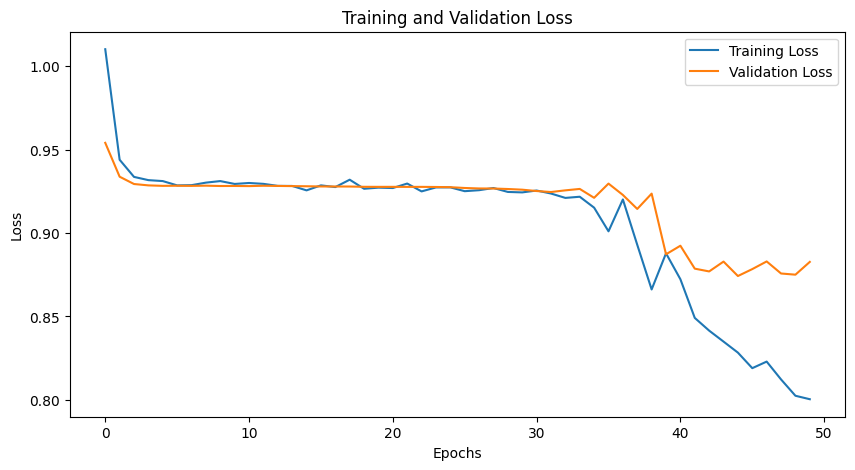

In [24]:
# In kết quả loss
print("Training Losses:", train_losses)
print("Validation Losses:", val_losses)

# Vẽ biểu đồ để trực quan hóa loss
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


In [25]:
# Đánh giá mô hình trên tập validation
val_loss, val_acc = evaluate(
    model,        # Mô hình đã huấn luyện
    val_loader,   # DataLoader của tập validation
    criterion,    # Hàm mất mát
    device        # Thiết bị (GPU hoặc CPU)
)

# Đánh giá mô hình trên tập test
test_loss, test_acc = evaluate(
    model,        # Mô hình đã huấn luyện
    test_loader,  # DataLoader của tập test
    criterion,    # Hàm mất mát
    device        # Thiết bị (GPU hoặc CPU)
)

# In kết quả đánh giá
print('Evaluation on validation/test datasets')
print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}')
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}')


Evaluation on validation/test datasets
Validation Loss: 0.8827, Validation Accuracy: 0.6258
Test Loss: 0.8306, Test Accuracy: 0.6351
